In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

In [2]:
# Load necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
# Step 1: Load and Inspect the Data
# Define how many lines you want to read
n_lines_to_read = 1500

In [4]:
# Option 1: Read only first n lines
data_lines = []
with open('rct_data.txt', 'r', encoding='utf-8') as file:
    for i, line in enumerate(file):
        if i >= n_lines_to_read:
            break
        data_lines.append(line.strip().split('\t'))

In [5]:
# Convert to DataFrame
columns = ['ID', 'Label', 'Year', 'Title', 'Abstract']
data = pd.DataFrame(data_lines, columns=columns)

In [6]:
# Convert Label to numeric
data['Label'] = data['Label'].astype(int)

In [7]:
# Display dataset info
print(f"Dataset shape: {data.shape}")
print(f"Number of RCTs (Label=1): {data['Label'].sum()}")
print(f"Number of non-RCTs (Label=0): {len(data) - data['Label'].sum()}")


Dataset shape: (1500, 5)
Number of RCTs (Label=1): 385
Number of non-RCTs (Label=0): 1115


<ipython-input-8-b23d58e5d2db>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Label', data=data, palette=['#ff9999','#66b3ff'])


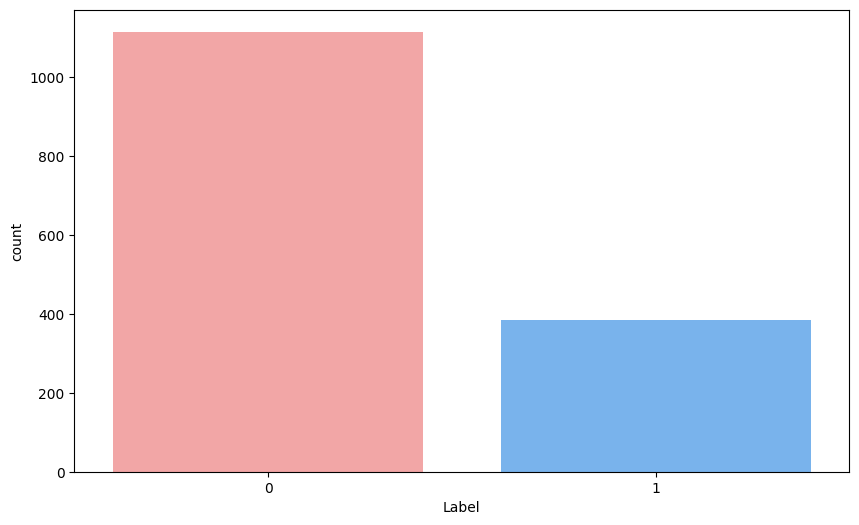

In [8]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
class_counts = data['Label'].value_counts()
class_percentages = 100 * class_counts / len(data)
ax = sns.countplot(x='Label', data=data, palette=['#ff9999','#66b3ff'])

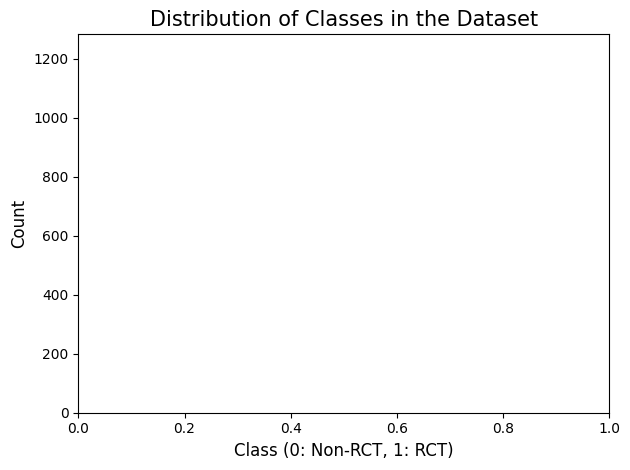

In [9]:
# Add count and percentage labels
for i, (count, percentage) in enumerate(zip(class_counts, class_percentages)):
    ax.text(i, count + 20, f'{count} ({percentage:.1f}%)',
            ha='center', va='bottom', fontsize=12)

plt.title('Distribution of Classes in the Dataset', fontsize=15)
plt.xlabel('Class (0: Non-RCT, 1: RCT)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.ylim(0, max(class_counts) * 1.15)  # Add space for text
plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
# Step 2: Preprocess the Data
data.dropna(subset=['Abstract'], inplace=True)

def preprocess_text(comment):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Lowercase
    comment = comment.lower()
    # Remove special characters and URLs
    comment = re.sub(r"http\S+|www\S+|https\S+", '', comment, flags=re.MULTILINE)
    comment = re.sub(r'\@\w+|\#','', comment)
    # Tokenization
    tokens = word_tokenize(comment)
    # Lemmatization and stop word removal
    comment = ' '.join([lemmatizer.lemmatize(word) for word in tokens if word not in stop_words])
    return comment

data['Abstract'] = data['Abstract'].apply(preprocess_text)
X = data['Abstract']
y = data['Label']

In [11]:
# Analyze common words in RCT vs. non-RCT abstracts
def generate_wordcloud(texts, title, filename):
    all_words = ' '.join(texts)
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                         max_words=100, contour_width=3, contour_color='steelblue').generate(all_words)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=15)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

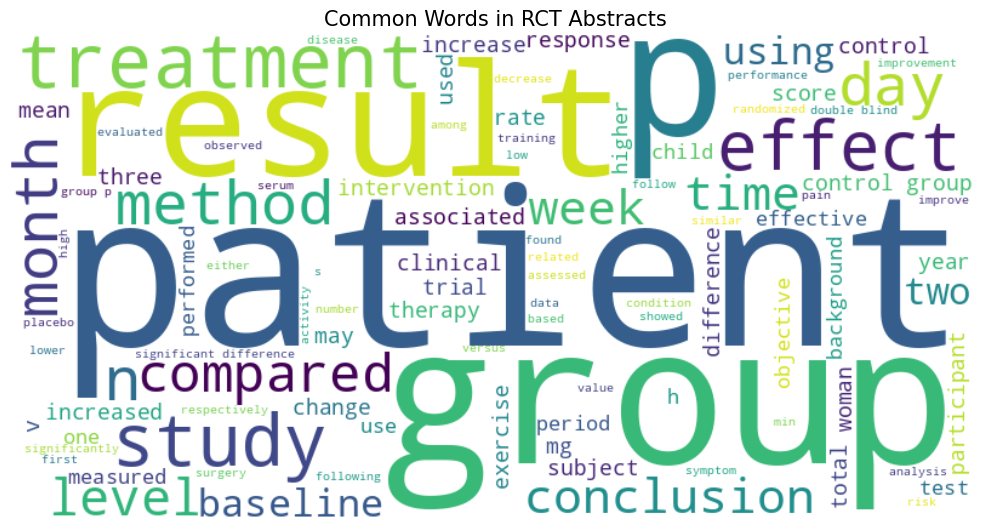

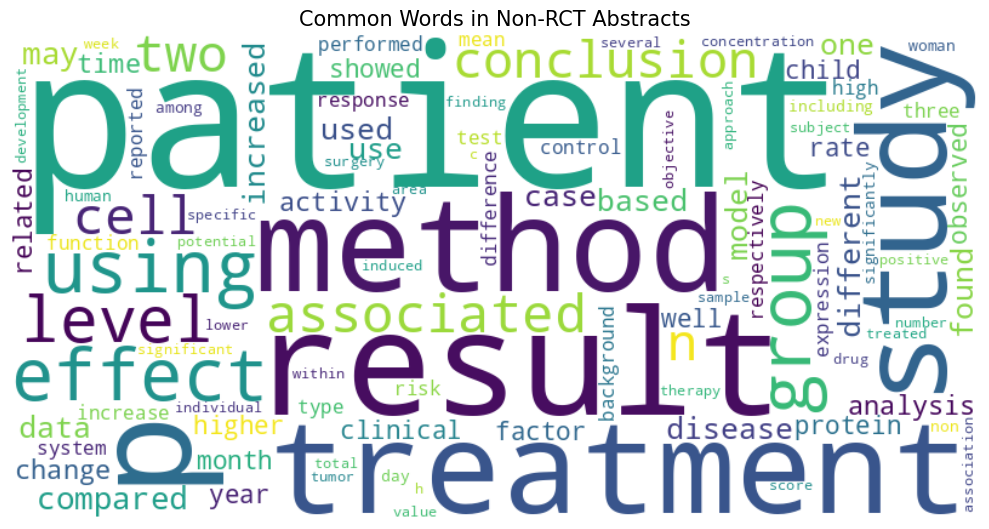

In [12]:
# Create word clouds for RCT and non-RCT abstracts
rct_abstracts = data[data['Label'] == 1]['Abstract']
non_rct_abstracts = data[data['Label'] == 0]['Abstract']

generate_wordcloud(rct_abstracts, 'Common Words in RCT Abstracts', 'rct_wordcloud.png')
generate_wordcloud(non_rct_abstracts, 'Common Words in Non-RCT Abstracts', 'non_rct_wordcloud.png')


In [13]:
# Step 3: Split the Data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [14]:
# Step 4: Vectorize the Text Data using TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_df=0.7)
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

In [15]:
# Get and visualize top TF-IDF features
def get_top_tfidf_features(feature_names, tfidf_scores, top_n=20):
    sorted_indices = np.argsort(tfidf_scores)[::-1][:top_n]
    top_features = [(feature_names[i], tfidf_scores[i]) for i in sorted_indices]
    return top_features

In [16]:
# Get feature names
feature_names = tfidf.get_feature_names_out()

In [17]:
# Get average TF-IDF score for each term
tfidf_means = X_train_tfidf.mean(axis=0).A1

In [18]:
# Get top features
top_features = get_top_tfidf_features(feature_names, tfidf_means)

In [19]:
# Visualize top TF-IDF features
plt.figure(figsize=(12, 8))
feat_names = [x[0] for x in top_features]
feat_scores = [x[1] for x in top_features]

<Figure size 1200x800 with 0 Axes>

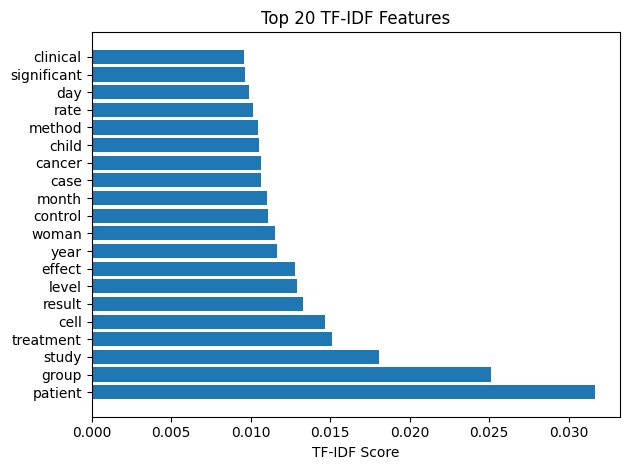

In [20]:
# Create horizontal bar chart
plt.barh(range(len(feat_names)), feat_scores, align='center')
plt.yticks(range(len(feat_names)), feat_names)
plt.xlabel('TF-IDF Score')
plt.title('Top 20 TF-IDF Features')
plt.tight_layout()
plt.savefig('top_tfidf_features.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
# Step 5: Train and Evaluate Multiple Models

# Model 1: Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_tfidf, y_train)
val_predictions_log_reg = log_reg.predict(X_val_tfidf)
print("Logistic Regression Validation Accuracy:", accuracy_score(y_val, val_predictions_log_reg))
print("Logistic Regression Validation Report:")
print(classification_report(y_val, val_predictions_log_reg))

Logistic Regression Validation Accuracy: 0.7666666666666667
Logistic Regression Validation Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       213
           1       0.95      0.21      0.34        87

    accuracy                           0.77       300
   macro avg       0.85      0.60      0.60       300
weighted avg       0.81      0.77      0.71       300



In [22]:
# Model 2: Support Vector Machine (SVM)
svm = SVC()
svm.fit(X_train_tfidf, y_train)
val_predictions_svm = svm.predict(X_val_tfidf)
print("SVM Validation Accuracy:", accuracy_score(y_val, val_predictions_svm))
print("SVM Validation Report:")
print(classification_report(y_val, val_predictions_svm))

SVM Validation Accuracy: 0.77
SVM Validation Report:
              precision    recall  f1-score   support

           0       0.76      0.99      0.86       213
           1       0.88      0.24      0.38        87

    accuracy                           0.77       300
   macro avg       0.82      0.61      0.62       300
weighted avg       0.79      0.77      0.72       300



In [23]:
# Model 3: Random Forest Classifier
rf = RandomForestClassifier()
rf.fit(X_train_tfidf, y_train)
val_predictions_rf = rf.predict(X_val_tfidf)
print("Random Forest Validation Accuracy:", accuracy_score(y_val, val_predictions_rf))
print("Random Forest Validation Report:")
print(classification_report(y_val, val_predictions_rf))

Random Forest Validation Accuracy: 0.8566666666666667
Random Forest Validation Report:
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       213
           1       0.94      0.54      0.69        87

    accuracy                           0.86       300
   macro avg       0.89      0.76      0.80       300
weighted avg       0.87      0.86      0.84       300



In [24]:
# Logistic Regression Test Evaluation
test_predictions_log_reg = log_reg.predict(X_test_tfidf)
print("Logistic Regression Test Accuracy:", accuracy_score(y_test, test_predictions_log_reg))
print("Logistic Regression Test Report:")
logistic_report = classification_report(y_test, test_predictions_log_reg, output_dict=True)
print(classification_report(y_test, test_predictions_log_reg))

Logistic Regression Test Accuracy: 0.7966666666666666
Logistic Regression Test Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       221
           1       0.95      0.24      0.38        79

    accuracy                           0.80       300
   macro avg       0.87      0.62      0.63       300
weighted avg       0.83      0.80      0.75       300



In [25]:
# SVM Test Evaluation
test_predictions_svm = svm.predict(X_test_tfidf)
print("SVM Test Accuracy:", accuracy_score(y_test, test_predictions_svm))
print("SVM Test Report:")
svm_report = classification_report(y_test, test_predictions_svm, output_dict=True)
print(classification_report(y_test, test_predictions_svm))

SVM Test Accuracy: 0.8266666666666667
SVM Test Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.89       221
           1       0.97      0.35      0.52        79

    accuracy                           0.83       300
   macro avg       0.89      0.67      0.71       300
weighted avg       0.85      0.83      0.80       300



In [26]:
# Random Forest Test Evaluation
test_predictions_rf = rf.predict(X_test_tfidf)
print("Random Forest Test Accuracy:", accuracy_score(y_test, test_predictions_rf))
print("Random Forest Test Report:")
rf_report = classification_report(y_test, test_predictions_rf, output_dict=True)
print(classification_report(y_test, test_predictions_rf))

Random Forest Test Accuracy: 0.87
Random Forest Test Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       221
           1       0.95      0.53      0.68        79

    accuracy                           0.87       300
   macro avg       0.91      0.76      0.80       300
weighted avg       0.88      0.87      0.86       300



In [28]:
# Visualize model comparison
models = ['Logistic Regression', 'SVM', 'Random Forest']
accuracy = [
    accuracy_score(y_test, test_predictions_log_reg),
    accuracy_score(y_test, test_predictions_svm),
    accuracy_score(y_test, test_predictions_rf)
]
precision = [
    logistic_report['1']['precision'],
    svm_report['1']['precision'],
    rf_report['1']['precision']
]
recall = [
    logistic_report['1']['recall'],
    svm_report['1']['recall'],
    rf_report['1']['recall']
]
f1_score = [
    logistic_report['1']['f1-score'],
    svm_report['1']['f1-score'],
    rf_report['1']['f1-score']
]

# Create a DataFrame for easier plotting
metrics_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1_score
})

# Visualize model performance comparison
plt.figure(figsize=(12, 10))

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<ipython-input-30-e51a28aa0734>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=metrics_df, palette='viridis')


([0, 1, 2],
 [Text(0, 0, 'Logistic Regression'),
  Text(1, 0, 'SVM'),
  Text(2, 0, 'Random Forest')])

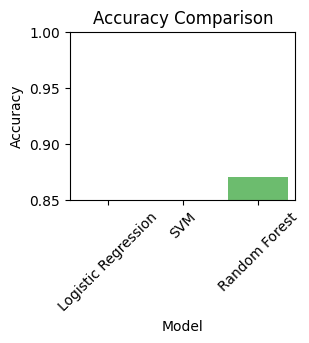

In [30]:
# Accuracy subplot
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='Accuracy', data=metrics_df, palette='viridis')
plt.title('Accuracy Comparison')
plt.ylim(0.85, 1.0)  # Adjust range to better show differences
plt.xticks(rotation=45)


<ipython-input-31-e20aa2fd1263>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Precision', data=metrics_df, palette='viridis')


([0, 1, 2],
 [Text(0, 0, 'Logistic Regression'),
  Text(1, 0, 'SVM'),
  Text(2, 0, 'Random Forest')])

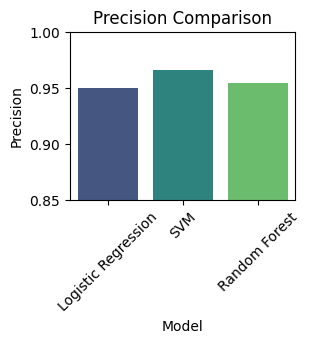

In [31]:
# Precision subplot
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='Precision', data=metrics_df, palette='viridis')
plt.title('Precision Comparison')
plt.ylim(0.85, 1.0)  # Adjust range to better show differences
plt.xticks(rotation=45)

<ipython-input-32-c208d985e3e2>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Recall', data=metrics_df, palette='viridis')


([0, 1, 2],
 [Text(0, 0, 'Logistic Regression'),
  Text(1, 0, 'SVM'),
  Text(2, 0, 'Random Forest')])

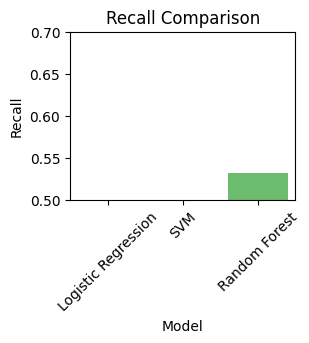

In [32]:
# Recall subplot
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='Recall', data=metrics_df, palette='viridis')
plt.title('Recall Comparison')
plt.ylim(0.5, 0.7)  # Adjust range to better show differences
plt.xticks(rotation=45)

<ipython-input-33-5e70a4649bd9>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='F1 Score', data=metrics_df, palette='viridis')


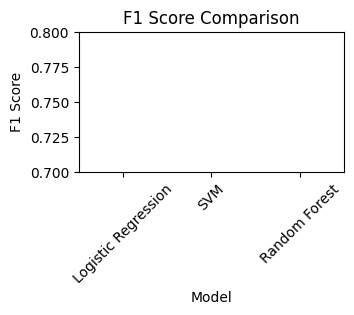

In [33]:
# F1 Score subplot
plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='F1 Score', data=metrics_df, palette='viridis')
plt.title('F1 Score Comparison')
plt.ylim(0.7, 0.8)  # Adjust range to better show differences
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('model_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

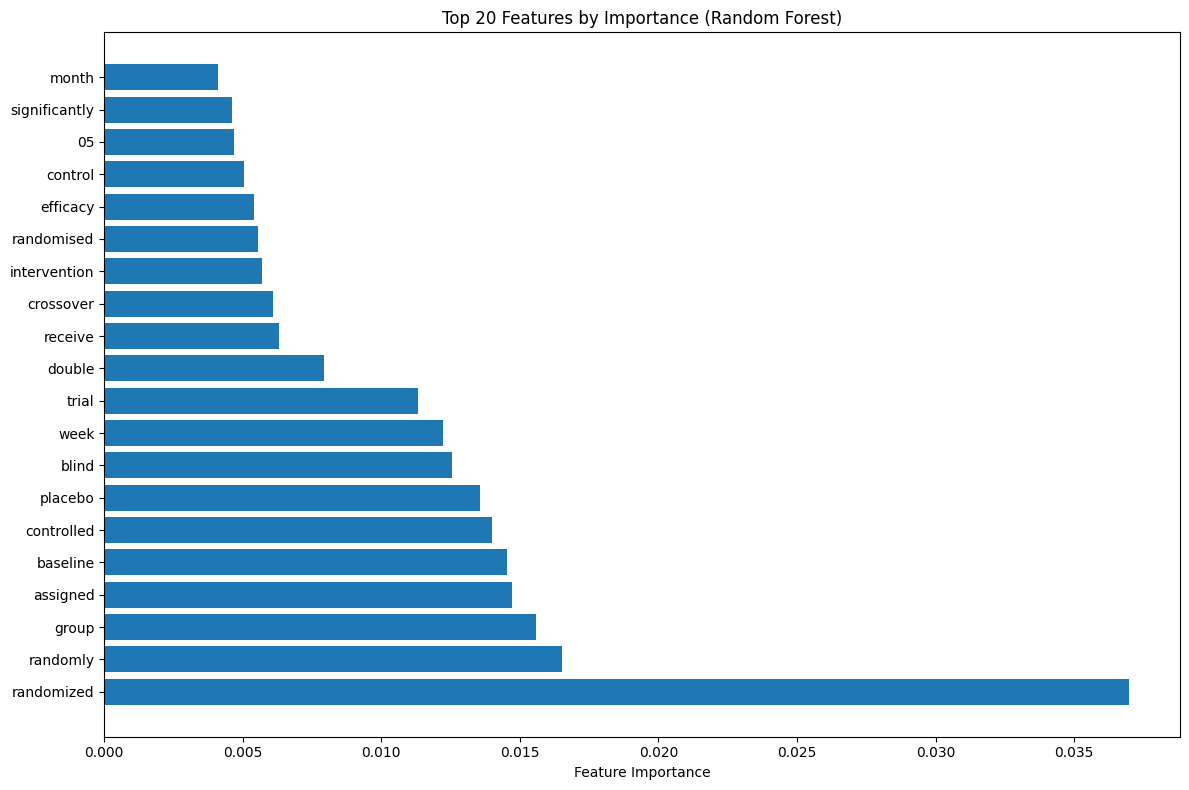

In [34]:
# Feature importance from Random Forest
if hasattr(rf, 'feature_importances_'):
    # Get feature importances
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Top 20 features
    top_n = 20
    top_indices = indices[:top_n]
    top_features = [feature_names[i] for i in top_indices]
    top_importances = [importances[i] for i in top_indices]

    # Visualize feature importances
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_features)), top_importances, align='center')
    plt.yticks(range(len(top_features)), top_features)
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Features by Importance (Random Forest)')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

In [35]:
# Visualize confusion matrices
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non-RCT', 'RCT'],
                yticklabels=['Non-RCT', 'RCT'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{model_name.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()

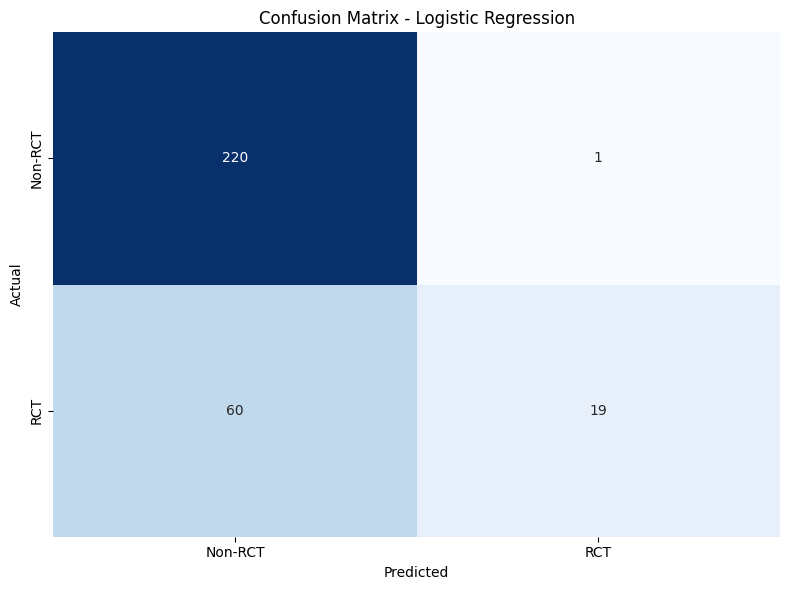

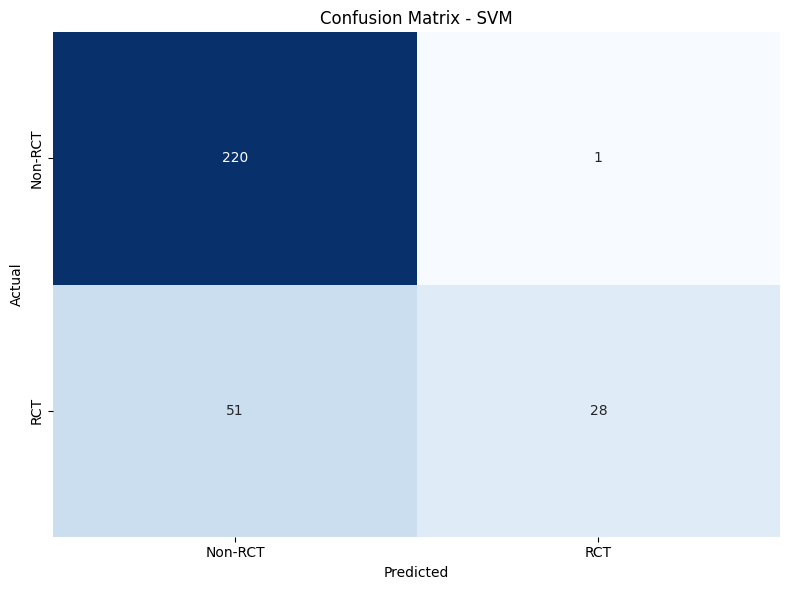

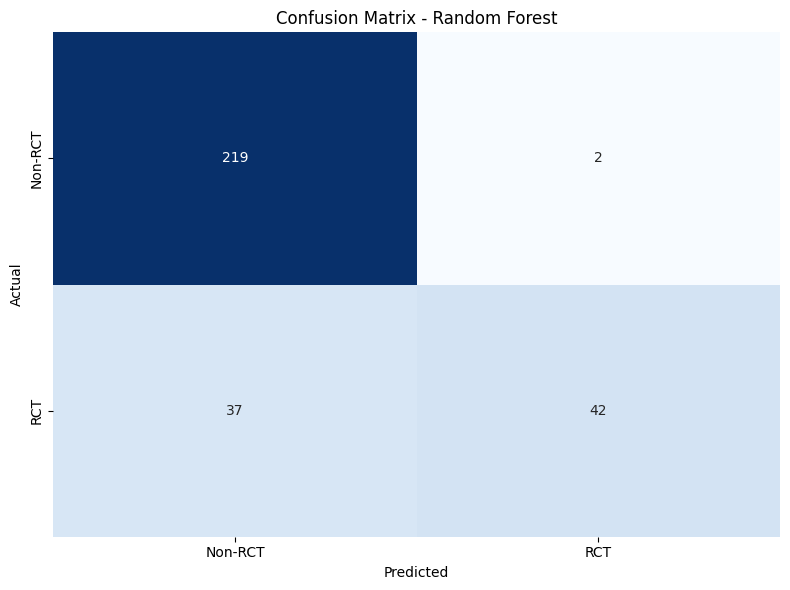

In [36]:
# Plot confusion matrices for all models
plot_confusion_matrix(y_test, test_predictions_log_reg, 'Logistic Regression')
plot_confusion_matrix(y_test, test_predictions_svm, 'SVM')
plot_confusion_matrix(y_test, test_predictions_rf, 'Random Forest')